Load and Visualize Data

In [0]:
#Download Data

!mkdir /data
!mkdir /data/data
!wget -P /data/ https://s3.amazonaws.com/video.udacity-data.com/topher/2018/May/5aea1b91_train-test-data/train-test-data.zip
!unzip -n /data/train-test-data.zip -d /data/data

In [0]:
!ls /data/data 

test  test_frames_keypoints.csv  training  training_frames_keypoints.csv


In [0]:
#import libraries

import numpy as np 
import pandas as pd 
import cv2
import matplotlib.pyplot as plt
import glob 
from PIL import Image
import matplotlib.image as mpimg
import os 
import torch
import random

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed = 0
seed_everything(seed)

In [0]:
#load training csv 

train_csv = pd.read_csv("/data/data/training_frames_keypoints.csv")
print (train_csv.head())
print (len(train_csv))

n = 0 
image_name = train_csv.iloc[n,0]
# key_pts = train_csv.iloc[n,1:].as_matrix().astype("float").reshape(-1,2)
key_pts = train_csv.iloc[n,1:].values.astype("float").reshape(-1,2)
print ("Image name = %r , Key Points Shape = %r , Sample Key Point = %r" %(image_name,key_pts.shape,key_pts[:5]))


                   Unnamed: 0     0     1     2  ...   132    133   134    135
0           Luis_Fonsi_21.jpg  45.0  98.0  47.0  ...  81.0  122.0  77.0  122.0
1       Lincoln_Chafee_52.jpg  41.0  83.0  43.0  ...  83.0  122.0  79.0  122.0
2       Valerie_Harper_30.jpg  56.0  69.0  56.0  ...  75.0  105.0  73.0  105.0
3         Angelo_Reyes_22.jpg  61.0  80.0  58.0  ...  91.0  139.0  85.0  136.0
4  Kristen_Breitweiser_11.jpg  58.0  94.0  58.0  ...  88.0  122.0  84.0  122.0

[5 rows x 137 columns]
3462
Image name = 'Luis_Fonsi_21.jpg' , Key Points Shape = (68, 2) , Sample Key Point = array([[ 45.,  98.],
       [ 47., 106.],
       [ 49., 110.],
       [ 53., 119.],
       [ 56., 125.]])


In [0]:
# visualize images 

def show_keypoint(image,key_pts):
  plt.imshow(image)
  plt.scatter(key_pts[:,0],key_pts[:,1],s=20,marker='.',c='m')  

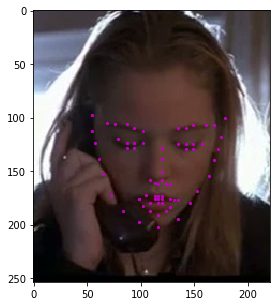

In [0]:
n = 3380
image_name = train_csv.iloc[n,0]
key_pts = train_csv.iloc[n,1:].values.astype("float").reshape(-1,2)

plt.figure(figsize=(5,5))
show_keypoint(Image.open("/data/data/training/" + image_name), key_pts)

In [0]:
#Custom Dataset Class

from torch.utils.data import DataLoader,Dataset 

class FacialKeypointsData(Dataset):
  def __init__(self,csv_file,root_dir,transform=None):
    self.root_dir = root_dir
    self.csv_file = pd.read_csv(csv_file)
    self.transform = transform
  
  def __len__(self):
    return len(self.csv_file)
  
  def __getitem__(self,idx):
    image_name = self.csv_file.iloc[idx,0]
    image = mpimg.imread(self.root_dir + "/" + image_name)
    
    #getting rid of alpha channel if an image has it 
    if image.shape[2] == 4:
      image = image[:,:,:3]
    key_pts = self.csv_file.iloc[idx,1:].values.astype("float").reshape(-1,2)
    sample = {'image':image,'key_pts':key_pts}
    if self.transform:
      sample = transform(sample)
    return sample

3462
0 2732 (260, 240, 3) (68, 2)
1 2607 (291, 202, 3) (68, 2)
2 1653 (143, 110, 3) (68, 2)


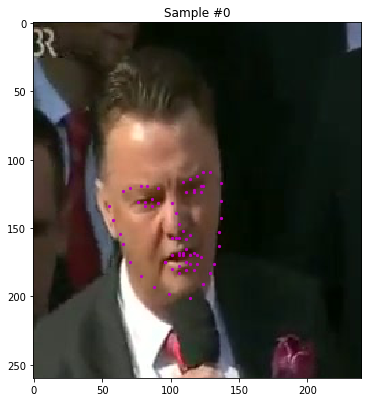

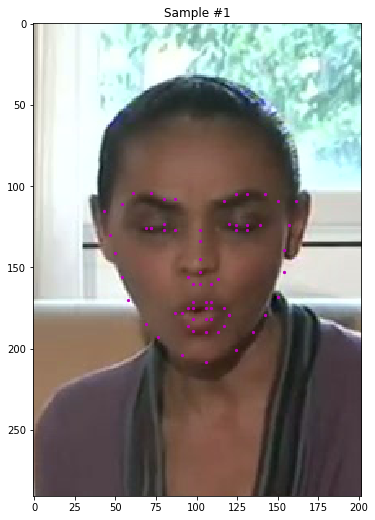

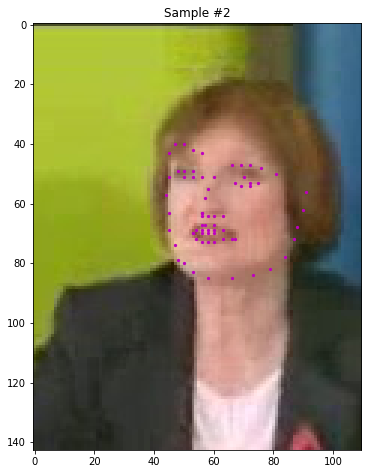

In [0]:
#Constructing and visualizing sample dataset 

sample_dataset = FacialKeypointsData("/data/data/training_frames_keypoints.csv","/data/data/training")
print (len(sample_dataset))

num_display = 3
for i in range(num_display):
  fig = plt.figure(figsize=(20,10))

  rand_i = np.random.randint(0,len(sample_dataset))
  sample = sample_dataset[rand_i]

  print (i,rand_i,sample['image'].shape,sample['key_pts'].shape)

  ax = plt.subplot(1, num_display, i + 1)
  ax.set_title('Sample #{}'.format(i))
  show_keypoint(sample['image'],sample['key_pts'])

In [0]:
#Transforms for image and keypoints 
import torch
from torchvision import transforms, utils

class Normalize(object):
  def __call__(self,sample):
    image = sample['image']
    key_pts = sample['key_pts']
    image_copy = np.copy(image)
    key_pts_copy = np.copy(key_pts)

    image_copy = cv2.cvtColor(image_copy,cv2.COLOR_RGB2GRAY)
    image_copy = image_copy/255.0
    
    key_pts = (key_pts - 100)/50.0

    return {'image':image_copy,'key_pts':key_pts}

class Rescale(object):
  def __init__(self,output_size):
    assert isinstance(output_size,(int,tuple))
    self.output_size = output_size
  
  def __call__(self,sample):
    image = sample['image']
    key_pts = sample['key_pts']

    h,w = image.shape[:2]
    if isinstance(self.output_size,int):
      if h > w :
        new_h, new_w = self.output_size * h/w, self.output_size
      else:
        new_h,new_w = self.output_size,self.output_size * (w/h)
    else:
      new_h,new_w = self.output_size
    new_w, new_h = int(new_w),int(new_h)    
    image = cv2.resize(image, (new_w,new_h))
    key_pts = key_pts * [new_w/w,new_h/h]

    return {'image':image,'key_pts':key_pts}

class RandomCrop(object):
  def __init__(self,output_size):
    assert isinstance(output_size,(int,tuple))
    if isinstance(output_size,int):
      self.output_size = (output_size,output_size)
    else:
      assert len(output_size) == 2
      self.output_size = output_size
  
  def __call__(self,sample):
    image = sample['image']
    key_pts = sample['key_pts']

    h,w = image.shape[:2]
    new_h,new_w = self.output_size

    top = np.random.randint(0, h - new_h)
    left = np.random.randint(0, w - new_w)

    image = image[top : top + new_h, left : left + new_w]
    key_pts = key_pts - [left,top]
    return {'image':image,'key_pts':key_pts}

class ToTensor(object):
  def __call__(self,sample):
    image = sample['image']
    key_pts = sample['key_pts']

    if len(image.shape)==2:
      image = image.reshape(image.shape[0],image.shape[1],1)
    
    image = image.transpose((2,0,1))
    return {'image':torch.from_numpy(image),'key_pts':key_pts}

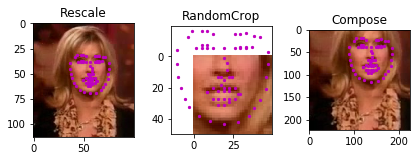

In [0]:
#Testing transform 

rescale = Rescale((100))
crop = RandomCrop((50))
transform = transforms.Compose([Rescale((250)),RandomCrop((224))])

num = 500
sample = sample_dataset[num]

fig = plt.figure()
for i, tx in enumerate([rescale,crop,transform]):
    transformed_sample = tx(sample)

    ax = plt.subplot(1, 3, i + 1)
    plt.tight_layout()
    ax.set_title(type(tx).__name__)
    show_keypoint(transformed_sample['image'], transformed_sample['key_pts'])

plt.show()

In [0]:
#Transformed Datasets

transform = transforms.Compose([Rescale(250),RandomCrop(224),Normalize(),ToTensor()])
train_data = FacialKeypointsData('/data/data/training_frames_keypoints.csv','/data/data/training',transform = transform)
test_data = FacialKeypointsData('/data/data/test_frames_keypoints.csv','/data/data/test',transform = transform)
batch_size = 64
train_loader = DataLoader(train_data,batch_size=batch_size,shuffle=True)
test_loader = DataLoader(test_data,batch_size=1,shuffle=False)
print (len(train_data),len(test_data))

3462 770
